In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import load_jsonl

pd.options.display.float_format = "{:.3f}".format

In [2]:
tournament_file = "./tournaments/rakuda_koukou_v0.jsonl"

In [3]:
charts_prefix = "./charts/" + tournament_file.split("/")[-1].split(".")[0]

# Load the matches

In [4]:
with open(tournament_file, 'r') as f:
    tournament = json.load(f)

In [5]:
df = pd.DataFrame(tournament['matches'])
df = df[["model1_id", "model2_id", "score"]]

In [6]:
df.head()  # score 1 -> model 1 victory, 2 -> model 2 victory, 3 -> draw

,model1_id,model2_id,score
0,rinna/japanese-gpt-neox-3.6b-instruction-ppo,izumi-lab/stormy-7b-10ep,1
1,gpt-3.5-turbo-0301:20230614,rinna/japanese-gpt-neox-3.6b,1
2,gpt-3.5-turbo-0301:20230614,rinna/japanese-gpt-neox-3.6b-instruction-ppo,1
3,rinna/japanese-gpt-neox-3.6b-instruction-ppo,rinna/japanese-gpt-neox-3.6b,1
4,rinna/japanese-gpt-neox-3.6b,rinna/japanese-gpt-neox-3.6b-instruction-ppo,2


##  Defining useful data quantities

In [7]:
# A mapping from a model to an integer index for convenience
model_to_int = {
    x: i
    for i, x in enumerate(
        df.groupby(["model1_id", "model2_id"]).size().unstack(fill_value=0).index
    )
}

int_to_model = {integer: model for model, integer in model_to_int.items()}

In [8]:
int_to_model

{0: 'cyberagent/open-calm-7b',
 1: 'gpt-3.5-turbo-0301:20230614',
 2: 'izumi-lab/stormy-7b-10ep',
 3: 'rinna/japanese-gpt-neox-3.6b',
 4: 'rinna/japanese-gpt-neox-3.6b-instruction-ppo',
 5: 'rinna/japanese-gpt-neox-3.6b-instruction-sft-v2'}

In [9]:
# Number of models
N = len(int_to_model)
# Number of matches
M = len(df)

print(f"{N} models played {M} matches")

6 models played 1200 matches


In [10]:
# Score vector
Y_m = (
    1 - (df["score"] - 1) / 2
).values  # 1 if i_m beat j_m in the mth game, .5 for a time, 0 otherwise

# match vectors: who played in the ith match
i_m = df.apply(lambda row: model_to_int[row["model1_id"]], axis=1).values
j_m = df.apply(lambda row: model_to_int[row["model2_id"]], axis=1).values

## Define the model

We model the probability that model $i$ in the first position beats model $j$ in the second position as 

$p_{ij} = \dfrac{e^{\alpha+\beta_i - \beta_j}}{1+e^{\alpha+\beta_i-\beta_j}}$

where $\beta_i$ is the strength of model $i$ and $\alpha$ is a home field advantage parameter that is greater than 0 if the model in the first position is favored over the model in the second position and is less than 0 if the second model is favored. Draws are counted as a half-win for each teams.

The log likelihood of the data given the parameters is then (see, e.g. https://web.stanford.edu/class/archive/stats/stats200/stats200.1172/Lecture24.pdf)

In [11]:
def l(alpha, betas, Y_m, i_m, j_m):
    betas_diff = betas[i_m] - betas[j_m]
    return np.sum(Y_m * (alpha + betas_diff) - np.log1p(np.exp(alpha + betas_diff)))

And the partial derivatives of the log likelihood with respect to the parameters are

In [12]:
def dldalpha(alpha, betas, Y_m, i_m, j_m):
    betas_diff = betas[i_m] - betas[j_m]
    exp_term = np.exp(alpha + betas_diff)
    dldalpha = np.sum(Y_m - exp_term / (1 + exp_term))
    return dldalpha

In [13]:
def dldbetai(alpha, betas, Y_m, i_m, j_m, i):
    betas_diff = betas[i_m] - betas[j_m]
    exp_term = np.exp(alpha + betas_diff)
    term = Y_m - exp_term / (1 + exp_term)

    dldbetai = np.sum(term[i_m == i]) - np.sum(term[j_m == i])
    return dldbetai

## We find the point in parameter space that maximizes the likelihood using scipy.optimize

In [14]:
import numpy as np
from scipy.optimize import minimize

# Initial guess for the parameters
x0 = np.zeros(N+1)

# Maximum number of iterations
max_iter = 1000

# Tolerance for stopping criteria
tol = 1e-6

# Define the system of equations
def F(x):
    return -l(x[0], x[1:], Y_m, i_m, j_m) + np.sum(x[:1]) ** 2

max_likelihood = minimize(F, x0)
print(f"Maximum Likelihood Solution is {max_likelihood}")
print(f"Beta sum: {np.sum(max_likelihood.x[1:])}")

Maximum Likelihood Solution is       fun: 714.0345182966124
 hess_inv: array([[0.00425591, 0.00071631, 0.00189088, 0.00034809, 0.00031845,
        0.00039355, 0.00029751],
       [0.00071631, 0.17461036, 0.16457934, 0.16505063, 0.16412567,
        0.16436146, 0.16490813],
       [0.00189088, 0.16457934, 0.17609093, 0.16492816, 0.16409611,
        0.16428774, 0.16477907],
       [0.00034809, 0.16505063, 0.16492816, 0.17553973, 0.16471647,
        0.16490576, 0.16546809],
       [0.00031845, 0.16412567, 0.16409611, 0.16471647, 0.17374161,
        0.16391768, 0.16460271],
       [0.00039355, 0.16436146, 0.16428774, 0.16490576, 0.16391768,
        0.17416538, 0.16472956],
       [0.00029751, 0.16490813, 0.16477907, 0.16546809, 0.16460271,
        0.16472956, 0.17529917]])
      jac: array([-7.62939453e-06,  7.62939453e-06, -7.62939453e-06,  7.62939453e-06,
        0.00000000e+00, -7.62939453e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 152
      nit:

## To quantify our confidence in these parameter values we run Markov Chain Monte Carlo using emcee

In [15]:
import emcee

# Parameter space dimension
ndim = N + 1

# Number of independent chains
nwalkers = 32

# Number of samples per chain
nsamples = 20000

# Likelihood
def l_for_emcee(x):
    return l(x[0], x[1:], Y_m, i_m, j_m) - np.sum(x[1:]) ** 2

# Initialize the walkers randomly around the MLE point 
p0 = np.random.normal(max_likelihood.x, 1, (nwalkers, ndim))

# Define the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, l_for_emcee)

# Run the MCMC
# this doesn't take more than like a minute to run. if too slow just reduce the nsamples/nwalkers, current numbers are overkill
sampler.run_mcmc(p0, nsamples);

In [16]:
print("Mean acceptance fraction: {0:.2f}".format(np.mean(sampler.acceptance_fraction)))
print(
    "Mean autocorrelation time: {0:.0f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean acceptance fraction: 0.49
Mean autocorrelation time: 79 steps


In [17]:
# Burn the first 1000 steps per chain to erase initial conditions 
flat_samples = sampler.get_chain(discard=1000, flat=True)
print(flat_samples.shape)

(608000, 7)


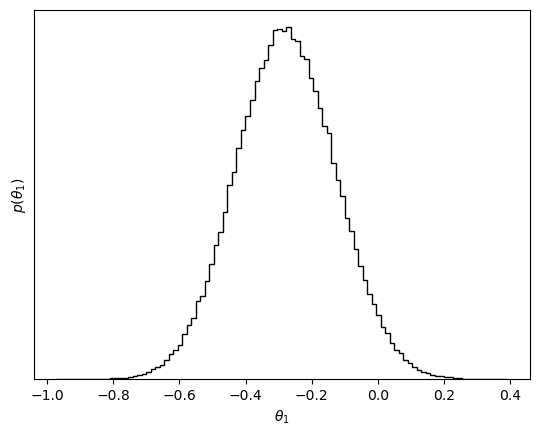

In [18]:
# Plot a parameter distribution
import matplotlib.pyplot as plt

plt.hist(flat_samples[:, 4], 100, color="k", histtype="step")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p(\theta_1)$")
plt.gca().set_yticks([]);

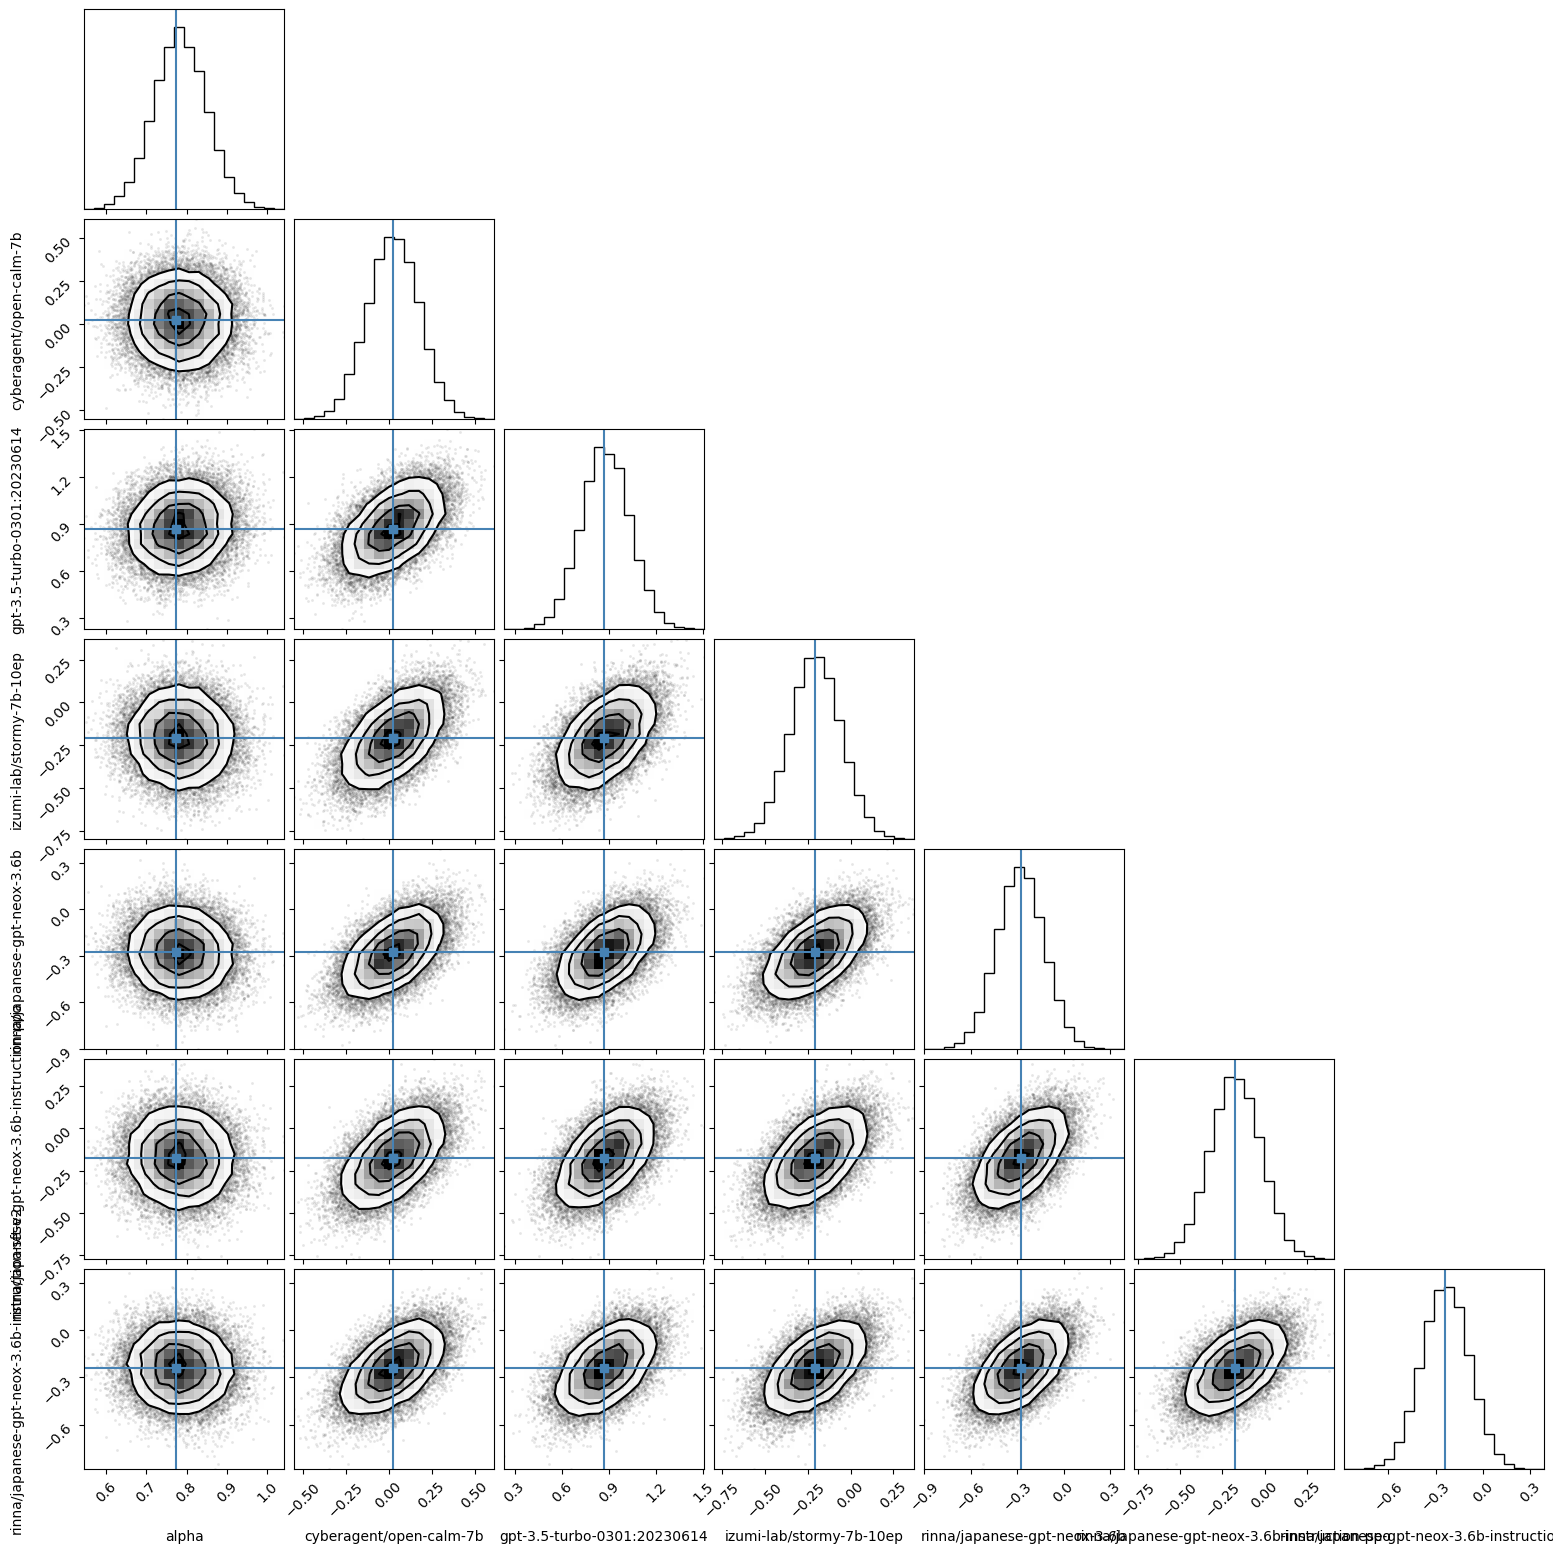

In [19]:
import corner

thin_samples = sampler.get_chain(discard=1000, thin=25, flat=True)

labels = ["alpha"] + [int_to_model[i] for i in range(N)]
fig = corner.corner(thin_samples, labels=labels, truths=max_likelihood.x);

In [20]:
from IPython.display import Math, display

parameters = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    print(mcmc[1], max_likelihood.x[i])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(max_likelihood.x[i], q[0], q[1], labels[i])
    display(Math(txt))

    parameters.append(
        {
            "parameter": labels[i],
            "mle": max_likelihood.x[i],
            "one_sigma_down": q[0],
            "one_sigma_up": q[1],
        }
    )

0.7838394214956133 0.7731029183785871


<IPython.core.display.Math object>

0.027488951585370604 0.02457191729260835


<IPython.core.display.Math object>

0.8779294513315996 0.8714167368967082


<IPython.core.display.Math object>

-0.20648382467206486 -0.20777994517221482


<IPython.core.display.Math object>

-0.2793909006199602 -0.27742632111363663


<IPython.core.display.Math object>

-0.17255458981163277 -0.17306661837474713


<IPython.core.display.Math object>

-0.2372308814533553 -0.23758880313796046


<IPython.core.display.Math object>

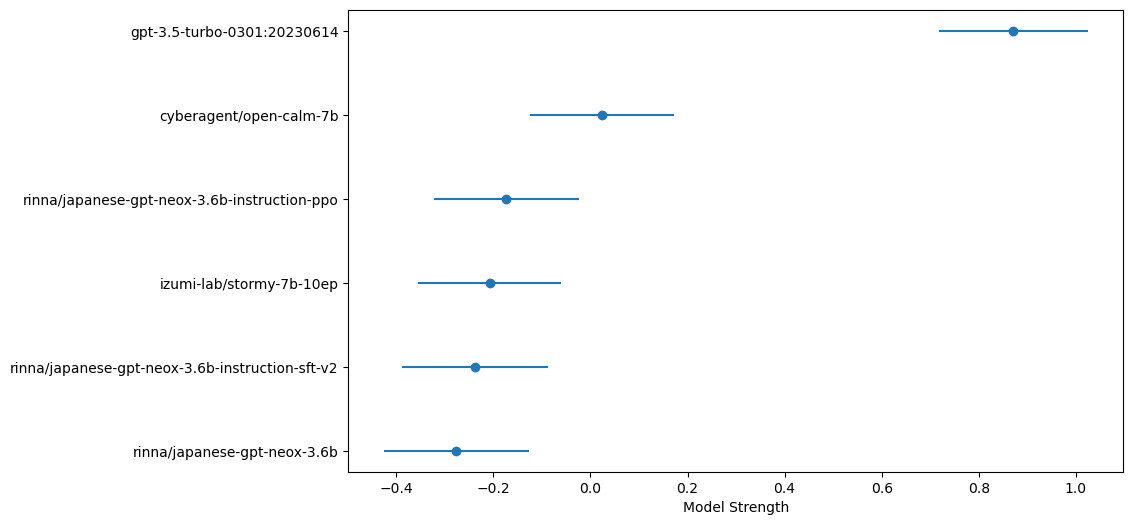

In [21]:
strengths = parameters[1:]
strengths = [{('model_id' if k == 'parameter' else k): v for k, v in d.items()} for d in strengths]

# Sort the models by strength
strengths.sort(key=lambda d: d["mle"])

# Get x values and error values
x_values = [d["mle"] for d in strengths]
errors = np.array([[d["one_sigma_down"], d["one_sigma_up"]] for d in strengths]).T
labels = [d["model_id"] for d in strengths]
y_values = range(len(x_values))

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(x_values, y_values, xerr=errors, fmt="o")
plt.xlabel("Model Strength")
plt.yticks(y_values, labels)
plt.savefig(charts_prefix + "ranking.png")
plt.show()

Note these errors are correlated, and we can calculate statistics for parameter differences (e.g. fraction of samples where model A > model B) 

In [22]:
modelA = 'cyberagent/open-calm-7b'
modelB = 'rinna/japanese-gpt-neox-3.6b'
A_stronger_rate = np.sum(flat_samples[:, model_to_int[modelA]+1] > flat_samples[:, model_to_int[modelB]+1])/len(flat_samples)
print(f'{modelA} is stronger than {modelB} with {A_stronger_rate:.2%} probability')

cyberagent/open-calm-7b is stronger than rinna/japanese-gpt-neox-3.6b with 98.43% probability


## Output standings

In [23]:
output = {
    "date": tournament['date'],
    "model_metadata": tournament['model_metadata'],
    "metadata": tournament['metadata'],
    "ranking": strengths,
}

In [24]:
output_path = f"./rankings/{tournament_file.split('/')[-1].split('.')[0]}.json"

In [25]:
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(output, f, ensure_ascii=False, indent=4)

In [26]:
from registry import StandingsRegistry

registry = StandingsRegistry("./registry/registry.jsonl")
registry.register("rankings/rakuda_koukou_v0.json")
registry.convert_to_markdown(
    "./registry/benchmark_template.md", "./registry/output/benchmark.md"
)


Converted elo ranking to markdown table


In [27]:
# Visualize